In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def create_temperature_categories(df):
    """
    Erstellt Temperaturkategorien basierend auf Quantilen für jede Jahreszeit separat
    """
    # Erstelle zunächst die Jahreszeiten-Spalte
    df['Season'] = df['Datum'].apply(get_season)
    
    # Initialisiere die Temperature_Category Spalte
    df['Temperature_Category'] = ''
    
    print("Temperaturkategorien pro Jahreszeit basierend auf Quantilen:")
    
    # Für jede Jahreszeit separate Quantile berechnen
    for season in df['Season'].unique():
        season_mask = df['Season'] == season
        season_temps = df.loc[season_mask, 'Temperatur']
        
        # Berechne Quantile für diese Jahreszeit
        temp_33_quantile = season_temps.quantile(0.33)
        temp_67_quantile = season_temps.quantile(0.67)
        
        # Kategorisiere Temperaturen für diese Jahreszeit
        def categorize_temperature_season(temp):
            if temp <= temp_33_quantile:
                return 'Cold'
            elif temp <= temp_67_quantile:
                return 'Medium'
            else:
                return 'Warm'
        
        # Wende Kategorisierung nur auf diese Jahreszeit an
        df.loc[season_mask, 'Temperature_Category'] = season_temps.apply(categorize_temperature_season)
        
        print(f"{season}:")
        print(f"  Cold: ≤ {temp_33_quantile:.1f}°C")
        print(f"  Medium: {temp_33_quantile:.1f}°C - {temp_67_quantile:.1f}°C")
        print(f"  Warm: > {temp_67_quantile:.1f}°C")
    
    return df

In [3]:
def get_season(date):
    """
    Bestimmt die Jahreszeit basierend auf dem Datum
    """
    month = date.month
    
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # month in [9, 10, 11]
        return 'Autumn'

In [4]:
def analyze_temperature_sales_by_season(df):
    """
    Analysiert Umsätze nach Temperaturkategorien und Jahreszeiten
    """
    # Stelle sicher, dass das Datum richtig formatiert ist
    if not pd.api.types.is_datetime64_any_dtype(df['Datum']):
        df['Datum'] = pd.to_datetime(df['Datum'])
    
    # Erstelle Temperaturkategorien pro Jahreszeit
    df = create_temperature_categories(df)
    
    # Gruppiere nach Jahreszeit und Temperaturkategorie
    seasonal_temp_sales = df.groupby(['Season', 'Temperature_Category'])['Umsatz'].agg(['sum', 'mean', 'count']).reset_index()
    seasonal_temp_sales.columns = ['Season', 'Temperature_Category', 'Total_Sales', 'Average_Sales', 'Count']
    
    print("\nUmsatz nach Jahreszeit und Temperaturkategorie:")
    print(seasonal_temp_sales)
    
    # Erstelle eine Pivot-Tabelle für bessere Visualisierung
    pivot_total = seasonal_temp_sales.pivot(index='Season', columns='Temperature_Category', values='Total_Sales')
    pivot_average = seasonal_temp_sales.pivot(index='Season', columns='Temperature_Category', values='Average_Sales')
    
    # Stelle sicher, dass alle Temperaturkategorien vorhanden sind
    temp_categories = ['Cold', 'Medium', 'Warm']
    for cat in temp_categories:
        if cat not in pivot_total.columns:
            pivot_total[cat] = 0
            pivot_average[cat] = 0
    
    # Ordne die Spalten
    pivot_total = pivot_total[temp_categories] / 1000  # Umsatz in Tausend
    pivot_average = pivot_average[temp_categories]
    
    # Ordne die Jahreszeiten logisch
    season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
    pivot_total = pivot_total.reindex([s for s in season_order if s in pivot_total.index])
    pivot_average = pivot_average.reindex([s for s in season_order if s in pivot_average.index])
    
    return df, seasonal_temp_sales, pivot_total, pivot_average

In [46]:
def create_temperature_sales_plots(df, pivot_total, pivot_average):
    """
    Erstellt die Balkendiagramme für Umsatz nach Temperatur und Jahreszeit
    """
    # Setze den Style
    #plt.style.use('seaborn-v0_8-whitegrid')
    
    # Erstelle eine Figure mit Subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    fig.suptitle('Turnover analysis by season and temperature', fontsize=16, fontweight='bold')
    
    # 1. Gesamtumsatz nach Jahreszeit und Temperaturkategorie
    ax1 = axes[0]
    pivot_total.plot(kind='bar', ax=ax1, color=['#33B8E0', '#e05b33', '#e03361'], alpha=0.7)
    ax1.set_title('Total turnover by season and temperature', fontweight='bold')
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Total turnover [k€]')
    ax1.legend(title='Temperature', loc='upper right', fontsize=10)
    ax1.tick_params(axis='x', rotation=0)
    ax1.grid(alpha=0.4, linestyle='--', axis='y')
    
    # 2. Durchschnittlicher Umsatz nach Jahreszeit und Temperaturkategorie
    ax2 = axes[1]
    pivot_average.plot(kind='bar', ax=ax2, color=['#33B8E0', '#e05b33', '#e03361'], alpha=0.7)
    ax2.set_title('Average turnover by season and temperature', fontweight='bold')
    ax2.set_xlabel('Season')
    ax2.set_ylabel('Average turnover [€]')
    ax2.legend(title='Temperature', loc='upper right', fontsize=10)
    ax2.tick_params(axis='x', rotation=0)
    ax2.grid(alpha=0.4, linestyle='--', axis='y')
    
    #ax3 = axes[1, 0]
    #temp_by_season = df.groupby(['Season', 'Temperature_Category']).size().unstack(fill_value=0)
    #temp_by_season = temp_by_season.reindex(['Spring', 'Summer', 'Autumn', 'Winter'])
    #temp_by_season[['Cold', 'Medium', 'Warm']].plot(kind='bar', ax=ax3, 
    #                                            color=['lightblue', 'orange', 'red'], alpha=0.8)
    #ax3.set_title('Anzahl der Tage pro Temperaturkategorie nach Jahreszeit', fontweight='bold')
    #ax3.set_xlabel('Jahreszeit')
    #ax3.set_ylabel('Anzahl der Tage')
    #ax3.legend(title='Temperaturkategorie')
    #ax3.tick_params(axis='x', rotation=45)
        
    # 4. Heatmap: Durchschnittlicher Umsatz
    #ax4 = axes[1, 1]
    #sns.heatmap(pivot_average, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Umsatz (€)'})
    #ax4.set_title('Heatmap: Durchschnittlicher Umsatz', fontweight='bold')
    #ax4.set_xlabel('Temperaturkategorie')
    #ax4.set_ylabel('Jahreszeit')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
        

In [47]:
def create_detailed_statistics(df, seasonal_temp_sales):
    """
    Erstellt detaillierte Statistiken für die Analyse
    """
    print("\n" + "="*60)
    print("DETAILLIERTE STATISTIKEN")
    print("="*60)
    
    # Gesamtstatistik
    total_sales = df['Umsatz'].sum()
    print(f"\nGesamtumsatz: {total_sales:,.2f} €")
    
    # Statistik nach Temperaturkategorie
    temp_stats = df.groupby('Temperature_Category')['Umsatz'].agg(['sum', 'mean', 'count'])
    temp_stats['percentage'] = (temp_stats['sum'] / total_sales) * 100
    print(f"\nUmsatz nach Temperaturkategorie:")
    print(temp_stats)
    
    # Statistik nach Jahreszeit
    season_stats = df.groupby('Season')['Umsatz'].agg(['sum', 'mean', 'count'])
    season_stats['percentage'] = (season_stats['sum'] / total_sales) * 100
    print(f"\nUmsatz nach Jahreszeit:")
    print(season_stats)
    
    # Beste Kombination identifizieren
    best_combo = seasonal_temp_sales.loc[seasonal_temp_sales['Total_Sales'].idxmax()]
    print(f"\nBeste Kombination (höchster Gesamtumsatz):")
    print(f"Jahreszeit: {best_combo['Season']}")
    print(f"Temperaturkategorie: {best_combo['Temperature_Category']}")
    print(f"Gesamtumsatz: {best_combo['Total_Sales']:,.2f} €")
    print(f"Durchschnittlicher Umsatz: {best_combo['Average_Sales']:,.2f} €")
    print(f"Anzahl Datensätze: {best_combo['Count']}")
    
    # Schlechteste Kombination identifizieren
    worst_combo = seasonal_temp_sales.loc[seasonal_temp_sales['Total_Sales'].idxmin()]
    print(f"\nSchlechteste Kombination (niedrigster Gesamtumsatz):")
    print(f"Jahreszeit: {worst_combo['Season']}")
    print(f"Temperaturkategorie: {worst_combo['Temperature_Category']}")
    print(f"Gesamtumsatz: {worst_combo['Total_Sales']:,.2f} €")
    print(f"Durchschnittlicher Umsatz: {worst_combo['Average_Sales']:,.2f} €")
    print(f"Anzahl Datensätze: {worst_combo['Count']}")

Starte Temperatur-Umsatz-Analyse nach Jahreszeiten...
Daten erfolgreich geladen: 10103 Zeilen
Temperaturkategorien pro Jahreszeit basierend auf Quantilen:
Winter:
  Cold: ≤ 2.5°C
  Medium: 2.5°C - 5.8°C
  Warm: > 5.8°C
Spring:
  Cold: ≤ 8.8°C
  Medium: 8.8°C - 13.1°C
  Warm: > 13.1°C
Summer:
  Cold: ≤ 18.4°C
  Medium: 18.4°C - 21.2°C
  Warm: > 21.2°C
Autumn:
  Cold: ≤ 9.8°C
  Medium: 9.8°C - 14.7°C
  Warm: > 14.7°C

Umsatz nach Jahreszeit und Temperaturkategorie:
    Season Temperature_Category  Total_Sales  Average_Sales  Count
0   Autumn                 Cold    126046.02     158.748136    794
1   Autumn               Medium    155997.53     194.026779    804
2   Autumn                 Warm    176110.68     219.589377    802
3   Spring                 Cold    136295.16     184.681789    738
4   Spring               Medium    151267.11     200.088770    756
5   Spring                 Warm    150668.33     205.831052    732
6   Summer                 Cold    199034.23     256.157310    

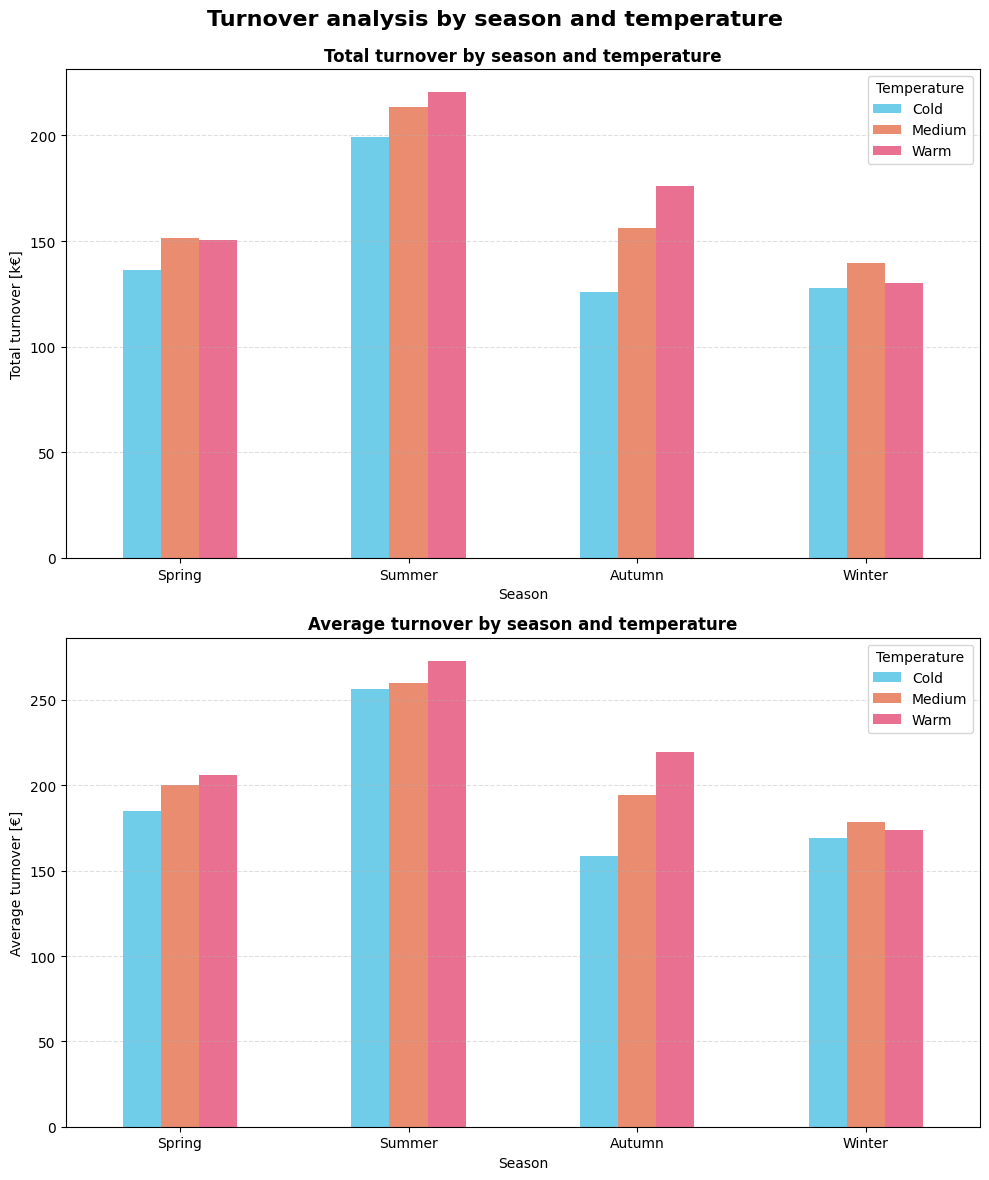

In [48]:
def main():
    """
    Hauptfunktion zur Ausführung der Temperatur-Umsatz-Analyse
    """
    print("Starte Temperatur-Umsatz-Analyse nach Jahreszeiten...")
    
    # Lade die Daten
    try:
        df = pd.read_csv('merged_data_clean.csv', parse_dates=['Datum'])
        print(f"Daten erfolgreich geladen: {len(df)} Zeilen")
    except Exception as e:
        print(f"Fehler beim Laden der Daten: {e}")
        return
    
    # Führe die Analyse durch
    df_analyzed, seasonal_temp_sales, pivot_total, pivot_average = analyze_temperature_sales_by_season(df)
    
    # Erstelle die Visualisierungen
    create_temperature_sales_plots(df_analyzed, pivot_total, pivot_average)
    
    # Erstelle detaillierte Statistiken
    create_detailed_statistics(df_analyzed, seasonal_temp_sales)
    
    #print(f"\nAnalyse abgeschlossen!")
    #print("Erstellte Dateien:")
    #print("- temperatur_umsatz_analyse.png (4-Panel Übersicht)")
    #print("- hauptbalkendiagramm_temperatur_umsatz.png (Hauptdiagramm)")

if __name__ == "__main__":
    main()